In [1]:
import myServices as ms
import models as md

import os
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
import joblib

In [ ]:
classifier = ms.loadModel('outputs/2022-11-01/10-51-40/2211011051.pkl')
x_test,y_test = ms.importDataSet('datasets/datasets4MLP_Binary/MLPBinary_basin1_Test.csv', 'percentage')

x_test = ms.removeCoordinatesFromDataSet(x_test)

# y_prob = classifier.predict_proba(x_test)
#print(np.unique(y_prob))

md.plot_ROC_AUC(classifier, x_test, y_test)

/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodProbabRNCanAbd/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodProbabRNCanAbd/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


[1.99985419e+00 9.99854190e-01 9.99771735e-01 ... 1.79190020e-22
 1.49442295e-22 4.68083094e-23]


/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodProbabRNCanAbd/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodProbabRNCanAbd/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


[1.99999469e+00 9.99994691e-01 9.99981159e-01 ... 1.35536933e-72
 1.28539142e-72 1.08663883e-72]


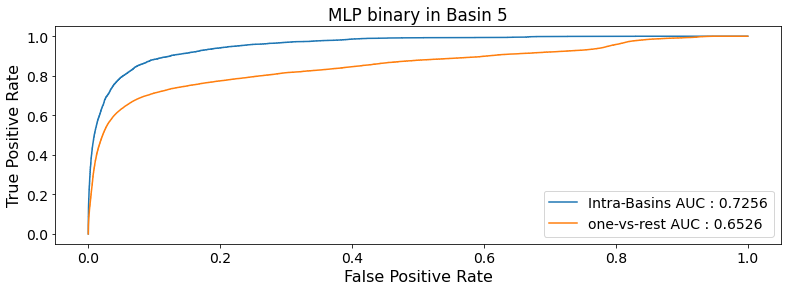

<Figure size 432x288 with 0 Axes>

In [24]:

fig, axs = plt.subplots(1,figsize=(13,4), sharey=True)
plt.rcParams.update({'font.size': 14})
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.figure(0).clf()
axs.set_title('MLP binary in Basin 5')

classifierList = ['outputs/2022-11-02/09-30-03/2211020930.pkl', 'outputs/2022-10-31/09-57-31/2210310957.pkl']
testSetList = ['datasets/datasets4MLP_Binary/MLPBinary_basin5_Test.csv', 'datasets/datasets4MLP_Binary/MLPBinary_basin5_VsAll_Test.csv']
nameList = ['Intra-Basins','one-vs-rest']
for i in range(len(classifierList)):
    classifier = ms.loadModel(classifierList[i])
    x_test,y_test = ms.importDataSet(testSetList[i], 'percentage')
    x_test = ms.removeCoordinatesFromDataSet(x_test)
    y_prob = classifier.predict_proba(x_test)  
    y_hat = classifier.predict(x_test)
    fpr,tpr,thresholds = metrics.roc_curve(y_test, y_prob[:,1], drop_intermediate=False) 
    print(thresholds)
    roc_auc = roc_auc_score(y_test, y_hat, average = "macro")
    axs.plot(fpr,tpr,label = str(nameList[i]) + " AUC : " + format(roc_auc,".4f")) 
    axs.legend()

In [ ]:
# to compute ececution time do: 
# with timeit():
#     # your code, e.g., 
class timeit(): 
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime: {}'.format(self.datetime.now() - self.tic))

## Importing and manipulating datasets

In [ ]:
sklearn.metrics.get_scorer_names()

In [31]:
### Import DataSet 
readSetPath = 'datasets/datasets4MLP/'
importName = 'MLP_basin5_Test.csv'
saveDatasetPath = 'datasets/datasets4MLP_Binary/'
basinDataSet = pd.read_csv((readSetPath+importName), index_col = None)

basinDataSet = ms.makeBinary(basinDataSet,'percentage',0,1)

exportName = 'MLPBinary_basin5_Test.csv'
basinDataSet.to_csv((saveDatasetPath+exportName), index=None)

basinDataSet.describe()
basinDataSet.head()

,elevation,FAcc,visibility,slope,DLSOL5R200,DLSOL5R150,DLSOL4R150,FAProx_025,FAProx_01,x_coord,y_coord,percentage
0,126.93661,0.00025,0.04961,0.45166,0.00840,0.00900,0.00236,111.80340,125.09996,360923.0,5275058.0,0
1,140.40877,0.00000,0.04261,1.79559,0.00372,0.00502,0.00000,393.73215,393.73215,362688.0,5277593.0,0
2,145.83328,0.00022,0.04728,1.19829,0.00874,0.00962,0.00791,5.00000,7.07107,363078.0,5278748.0,0
3,54.81872,0.00001,0.02250,15.01212,0.01044,0.01360,0.00274,98.99495,98.99495,361573.0,5276408.0,0
4,77.33813,0.00000,0.05342,10.97649,0.01172,0.01169,0.00291,55.00000,134.62912,361673.0,5276953.0,0


In [ ]:
colNames = ['percentage','DLSOL5R200', 'DLSOL4R150', 'DLSOL5R150']
for col in colNames: 
    basinDataSet[col].fillna(0,inplace=True)

In [21]:
## Transform a column datatype
repalcer  = basinDataSet['percentage'].to_numpy().astype('int32')
print(repalcer[0:10],repalcer.dtype)
basinDataSet.loc[:,'percentage'] = repalcer

[0 0 0 0 0 0 0 0 0 0] int32


In [22]:
### Make binary Dataset ###
# keep class_0 and replace with 1 all other classes. 
basinDataSet = ms.makeBinary(basinDataSet,'percentage',0,1)


In [27]:
basinDataSet.describe()

,LDSOL5R200,LDSOL5R150,LDSOL4R150,FAProx_025,FAProx_01,visibility,FAcc,slope,elevation,x_coord,y_coord,percentage
count,55451.000000,55451.000000,55451.000000,55451.000000,55451.000000,55451.000000,55451.000000,55451.000000,55451.000000,55451.000000,5.545100e+04,55451.000000
mean,0.006465,0.006516,0.003014,269.635808,179.749746,0.060547,0.001992,6.377995,136.643791,361058.846964,5.273243e+06,0.057510
std,0.003561,0.004278,0.003039,200.630954,130.826757,0.047393,0.031002,6.011301,30.054986,917.411895,1.107013e+03,0.232817
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000080,0.000000,0.001220,1.434400,359153.000000,5.270818e+06,0.000000
25%,0.003800,0.003110,0.000000,109.658570,72.111020,0.027000,0.000010,2.270890,129.194925,360258.000000,5.272333e+06,0.000000
50%,0.006430,0.006250,0.002320,228.527890,155.000000,0.046570,0.000030,4.925180,142.671520,361113.000000,5.273348e+06,0.000000
75%,0.008910,0.009470,0.005270,389.486850,265.424190,0.081670,0.000110,8.548120,153.077140,361828.000000,5.274048e+06,0.000000
max,0.018990,0.021440,0.012770,971.866760,664.849610,0.437450,0.987490,67.247570,215.482250,362853.000000,5.275598e+06,1.000000


In [28]:
basinDataSet.head()

,LDSOL5R200,LDSOL5R150,LDSOL4R150,FAProx_025,FAProx_01,visibility,FAcc,slope,elevation,x_coord,y_coord,percentage
0,0.00889,0.00573,0.00043,141.50972,141.50972,0.06692,0.00000,9.06672,130.94017,360243,5274248,0
1,0.00152,0.00001,0.00000,876.81244,434.10828,0.20336,0.00004,7.19772,174.65186,359968,5271153,0
2,0.00978,0.01067,0.00550,107.00467,107.00467,0.01869,0.00012,13.66632,63.74500,359728,5274558,0
3,0.00868,0.00885,0.00484,55.00000,55.00000,0.07109,0.00000,0.38351,125.55405,360913,5273953,0
4,0.00702,0.00338,0.00128,228.08989,156.60460,0.06147,0.00000,2.54051,153.73796,361913,5272473,0


In [14]:
basinDataSet.isna().any()

percentage    False
FAcc          False
slope         False
elevation     False
x_coord       False
y_coord       False
DLSOL4R150    False
DLSOL5R150    False
DLSOL5R200    False
FAProx_01     False
FAProx_025    False
visibility    False
dtype: bool

In [25]:
exportName = 'MLPBinary_basin3_Training.csv'
basinDataSet.to_csv((saveDatasetPath+exportName), index=None)

In [16]:
### Replacing QGIS NoData value(-9999) with 0 
repalcer  = basinDataSet['FAProx_01'].to_numpy()
basinDataSet['FAProx_01'] = [0 if repalcer[j] == -9999 else repalcer[j] for j in range(len(repalcer))]                                                                                                                         
                                                                                                                          

In [ ]:
basinDataSet.dropna(subset=['slope'],inplace=True)

In [ ]:
basinDataSet.drop(['fid'], axis =1, inplace=True)

In [ ]:
basinDataSet.isna().sum()

In [ ]:
#### NOrmalize Flow Accumulation
basinDataSet['FAcc'] = (basinDataSet['FAcc']- basinDataSet['FAcc'].min())/(basinDataSet['FAcc'].max()-basinDataSet['FAcc'].min())


In [ ]:
ds = DS.head(5)
s = {}
s['Datas'] = ds
print(s)

## Proportional Spliting 

In [ ]:
## Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit

X,Y = ms.importDataSet('datasets/basin1_FirstFeatureSet_Clean.csv', 'percentage')
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index.size, "TEST:", test_index.size)
    X_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = Y.iloc[test_index]

In [ ]:
## Describing training set
print(len(X_train['elevation']), len(y_train) )
trainCount = Counter(y_train)
print(trainCount)

In [ ]:
#####    Creating training set     #####
X_train.loc[:,'percentage'] = y_train
X_train.head()


In [ ]:
## Removing coordinates from training set
X_train.drop(['x_coord','y_coord'], axis =1, inplace=True)
X_train.head()

In [ ]:
X_train.to_csv('datasets/basin1_FirstFeatureSet_Clean_Training.csv', index=None)

In [ ]:
#####. Creating Test set
print(X_test.head())
X_test.loc[:,'percentage'] = y_test
print(X_test.head())
print(X_test.info())
testCount = Counter(X_test['percentage'])
print(f"testCount:  {testCount}")


In [ ]:
X_test.to_csv('datasets/basin1_FirstFeatureSet_Clean_Test.csv', index=None)

In [ ]:
## This proportions are the reason why a sample_weight of 0.01 for the majority class give best results for regression
totalTrain = sum([trainCount[0], trainCount[1], trainCount[5]]) 
totalValidation = sum([testCount[0], testCount[1], testCount[5]])
print(f"total Train samples: {totalTrain},  total Validation samples: {totalValidation}")
print("Summary of traning and test dataset class balance")
print(f"Training Set:", '\n', "Class 0: %.3f" %(trainCount[0]/totalTrain), " Class 1: %.4f" %(trainCount[1]/totalTrain), "Class 5: %.4f"%(trainCount[5]/totalTrain))
print("Testing Set:", '\n', "Class 0: %.3f" %(testCount[0]/totalValidation)," Class 1: %.4f" %(testCount[1]/totalValidation),  "Class 5: %.4f"%(testCount[5]/totalValidation))



In [ ]:
model = ms.loadModel('./outputs/2022-08-05/00-35-58/2208050035.pkl')
dataSetToSave = ms.makePredictionToImportAsSHP(csvName, model, X, Y, 'percentage')
print(dataSetToSave.head())

## Combining dataSets to build AllVsOne_training and OneVsAll_test

In [ ]:
# Concat datasets
sourceFileForDatasets = 'datasets/'
allDataSetsNames = ['basin1Light_Clean.csv', 'basin2_CleanDataSet.csv', 'basin3_CleanDataSet_copy.csv','basin4_CleanDataSet.csv','basin5_CleanDataSet.csv']
# OneVsAllDataSetName = 'basin1Light_Clean.csv'

for datasetForTest in allDataSetsNames:
    filename, file_extension = os.path.splitext(datasetForTest)
    newListOfNames = [s for s in allDataSetsNames if s != datasetForTest]
    allDataSetsFileName = 'allVs_'+ filename +'_Training'
    DFToConcatAll = pd.DataFrame()
#     DFToConcatAll = pd.read_csv((sourceFileForDatasets+datasetForTest), index_col = None)
#     print(DFToConcatAll.head())
    for datasets in newListOfNames:
        DFToConcatAll = pd.concat([DFToConcatAll, pd.read_csv((sourceFileForDatasets+datasets), index_col = None)])
    nameToSafe = sourceFileForDatasets+allDataSetsFileName+file_extension
    DFToConcatAll.drop(['x_coord','y_coord'], axis =1, inplace=True)
    DFToConcatAll.to_csv(nameToSafe, index=None)    
    



## Preparing datasets for MLP

In [ ]:
destiationPath = 'datasets/RFdatasets'
listFile = os.listdir(destiationPath)
print(listFile)

In [ ]:
testList = ['basin1Light_Clean_Test.csv','basin2_Test.csv','basin3_Test.csv','basin4_Test.csv','basin5_Test.csv']
traininList = ['basin1Light_Clean_Training.csv','basin2_Training.csv','basin3_Training.csv','basin4_Training.csv','basin5_Training.csv']

In [ ]:
## Cleaning datasets: Removing not usefull variables from All_VS_ONE 
readPath = 'datasets/RFdatasets/'
destiationPath = 'datasets/dataset4MLP/'
datasetNamelist = ['basin1Light_Clean_Test.csv','basin2_Test.csv','basin3_Test.csv','basin4_Test.csv','basin5_Test.csv',
                  'basin1Light_Clean_Training.csv','basin2_Training.csv','basin3_Training.csv','basin4_Training.csv',
                   'basin5_Training.csv']
featuresToDelete = ['TPI','TWI']
for i in datasetNamelist:
    path = readPath + i 
    basinDataSet = pd.read_csv(path, index_col = None)
    basinDataSet.drop(featuresToDelete, axis=1, inplace=True)
    savePath = destiationPath + 'MLP_'+ i
    basinDataSet.to_csv(savePath, index=None)


In [ ]:
###. Build dataset subset for MLP test (Only first 150K samples)
readPath = 'datasets/dataset4MLP/'
datasetNamelist = ['MLP_allVs_basin1Light_Clean_Training.csv','MLP_basin1Light_Clean_VsAll_Test.csv']
for i in datasetNamelist:
    path = readPath + i 
    basinDataSet = pd.read_csv(path, index_col = None)
    Y = np.array(basinDataSet['percentage'])
    count,_ = md.listClassCountPercent(Y)
    basinDataSet.drop(basinDataSet.loc[150000:count].index,axis=0,inplace=True)
    savePath = readPath + 'reduced_'+i
    basinDataSet.to_csv(savePath, index=None)

In [ ]:
### Exploring datasets
dataset = ['reduced_MLP_allVs_basin1Light_Clean_Training.csv','reduced_MLP_basin1Light_Clean_VsAll_Test.csv']
for i in dataset:
    path = readPath + i 
    print(path)
    basinDataSet = pd.read_csv(path, index_col = None)
    print(basinDataSet.head())
    Y = np.array(basinDataSet['percentage'])
    print(md.listClassCountPercent(Y))

In [ ]:
####.  Training TEST
readPath = 'datasets/dataset4MLP/'
trainingPath = readPath + 'MLP_allVs_basin1Light_Clean_Training.csv'
params = {'random_state':50, 'hidden_layer_sizes': 2,
                'early_stopping':True,'max_iter':200,'verbose':False,
                'tol':0.00010,'validation_fraction':0.1,'warm_start':False}
mlpc = md.implementingMLPCalssifier(trainingPath,'percentage',params)
mlpc.fitMLPClassifier()
mlpc.plotLossBehaviour()

mlpClassifier = mlpc.getMLPClassifier()

# #Validating un unseen datase
# validation = readPath + 'MLP_basin1Light_Clean_VsAll_Test.csv'
# x_val,y_val = ms.importDataSet(validation, 'percentage')
# prediction = ms.makePredictionToImportAsSHP(mlpClassifier, x_val, y_val, 'percentage')

# ## Compute metrics
# X = x_val.copy()
# X.drop(['x_coord','y_coord'], axis=1, inplace=True)
# metrics = md.computeClassificationMetrics(mlpClassifier,X,y_val)

In [ ]:
print(mlpc.get_logsDic())
mlpc.logMLPClassifier({'test':34})
print(mlpc.get_logsDic())

In [ ]:
prediction.to_csv(('outputs/'+ 'MLP_basin1Light_firstResult_HL280.csv'),index=None)

In [ ]:
### Implement bets hiddenLayerSize exploration
readPath = 'datasets/dataset4MLP/'
trainingPath = readPath + 'MLP_allVs_basin1Light_Clean_Training.csv'
validation = readPath + 'MLP_basin1Light_Clean_VsAll_Test.csv'
# dataset = pd.read_csv(trainingPath, index_col = None)
params = {'random_state':50, 'hidden_layer_sizes': 2,
                'early_stopping':False,'max_iter':2,'verbose':True,
                'tol':0.00010,'validation_fraction':0.1,'warm_start':False}
mlpc = md.implementingMLPCalssifier(trainingPath,'percentage',params)

x_val,Y_val = ms.importDataSet(validation, 'percentage')
X = x_val.copy()
X.drop(['x_coord','y_coord'], axis=1, inplace=True)
firstInterval = np.arange(100,1009,100)
mlpc.explore4BestHLSize(X,Y_val,firstInterval,'5',3)

## Controled sampling

In [ ]:
DS = pd.read_csv('datasets/basin2 _Training.csv', index_col = None)
print(DS.head())


In [ ]:
print(DS.columns)

In [ ]:
plt.boxplot(DS['FAProx_01']) # , , DS['elevation'], DS['disToRiv']]

In [ ]:
## Resampling appliying class selection by rule:

# RULE1: Select point at a distance to river less than 300m. 

# # newDS = pseudoClassCreation(DS, "distanceToRiver", 300, 2)
def pseudoClassCreation(dataset, conditionVariable, threshold, pseudoClass, targetClassName):
    '''
    Replace <targetClass> by  <pseudoClass> where <conditionVariable >= threshold>. 
    Return:
      dataset with new classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    conditionVar = (np.array(dataset[conditionVariable])).ravel()
    datsetReclassified[targetClassName] = [ pseudoClass if conditionVar[j] >= threshold 
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified

def revertPseudoClassCreation(dataset, originalClass, pseudoClass, targetClassName):
    '''
    Restablich  <targetClass> with <originalClass> where <targetClassName == pseudoClass>. 
    Return:
      dataset with original classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    datsetReclassified[targetClassName] = [ originalClass if actualTarget[j] == pseudoClass
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified


print(Counter(X_train['percentage']))
newDS = pseudoClassCreation(X_train, 'disToRiv', 200, 2, 'percentage')
y = newDS['percentage']
newDS.drop(['percentage'], axis=1, inplace = True)
x_res,y_res = ms.randomUndersampling(newDS, y, )
x_res['percentage'] = y_res
# newDatase = revertPseudoClassCreation(x_res, 0, 2, 'percentage')


In [ ]:
x_res.to_csv('basin1ControlClass0Sampling4Class_ToSHP.csv',index = None)

# Data description and visualization

In [ ]:
#### import dataset to describe
DS= pd.read_csv('datasets/basin4_Training.csv', index_col=None)
DS.head()

In [ ]:
DS.drop(['x_coord','y_coord'], axis = 1, inplace=True)
DS.head()

In [ ]:
### FAcc vs Labels
targets = DS['percentage']
FAcc = original['FAcc']
FAcc_norm = DS['FAcc_norm']
fig, axs = plt.subplots(1, 2, figsize=(13,4), sharey=True)
fig.text(-0.02, 0.5, 'labels', va='center', rotation='vertical')
fig.text(0.5, 1, 'Flow accumulation vs labels distribution', ha ='center')
axs[0].scatter(FAcc,targets)
# axs[0].set_title("Facc")
axs[0].set(xlabel='a) Flow Accumulation')
axs[1].scatter(FAcc_norm,targets)
# axs[1].set_title("FAcc_norm")
axs[1].set(xlabel='b) Flow Accumulation estandardized')
plt.rcParams['font.size'] = '20'
fig.tight_layout()


In [ ]:

## Plot all features vs labels
# 'disToRiv', 'TWI', 'TPI', 'slope', 'elevation',

targets = DS['percentage']
# targets = np.where(targets == 5,2,targets)

E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
TPI = DS['TPI']
DLSOL4R150 = DS['LDSOL4R150']
DLSOL5R150 = DS['LDSOL5R150']
DLSOL5R200 = DS['LDSOL5R200']
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']

fig, axs = plt.subplots(4,3, figsize=(13, 8), sharey=True)
fig.supylabel('Labels')
plt.rcParams['font.size'] = '15'
plt.yticks([0,1,5])

'''
E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
'''
axs[0, 0].scatter(E,targets)
axs[0, 0].set_title("Elevation")
axs[1, 0].scatter(slope,targets)
axs[1, 0].set_title("Slope")
axs[2, 0].scatter(FAcc,targets)
axs[2, 0].set_title("Flow accumulation")
axs[3, 0].scatter(TWI,targets)
axs[3, 0].set_title("TWI")

'''
TPI = DS['TPI']
DLSOL4R150 = DS['DLSOL4R150']
DLSOL5R150 = DS['DLSOL5R150']
DLSOL5R200 = DS['DLSOL5R200']
'''
axs[0, 1].scatter(TPI,targets)
axs[0, 1].set_title('TPI')
axs[1, 1].scatter(DLSOL4R150,targets)
axs[1, 1].set_title("DLSOL4R150")
axs[2, 1].scatter(DLSOL5R150,targets)
axs[2, 1].set_title("DLSOL5R150")
axs[3, 1].scatter(DLSOL5R200,targets)
axs[3, 1].set_title("DLSOL5R200")

'''
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']
'''
axs[0, 2].scatter(FAProx_01,targets)
axs[0, 2].set_title('FAProx_01')
axs[1, 2].scatter(FAProx_025,targets)
axs[1, 2].set_title("FAProx_025")
axs[2, 2].scatter(visibility,targets)
axs[2, 2].set_title("Visibility")

fig.tight_layout()


In [ ]:
print(DS.head())
#  Return a dataset with the rows corresponding to the index where condition in DS.columName is valid. 
dsArray = DS[DS.percentage != 0] 
print(dsArray.head()) 

In [ ]:
sns.set(font_scale=1.5)
sns.pairplot(DS, hue = 'percentage', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.8, 's': 100},
             height = 4, corner=True, palette = "Set2")# vars = ['life_exp', 'log_pop', 'log_gdp_per_cap'],

# sns.pairplot(DS, hue="percentage")

In [ ]:
####. Covariance Matrix
sns.set(font_scale=0.7)
matrix = DS.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.set_figsize=(25,20)
plt.show()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(criterion='entropy', random_state = 50)
x_train,y_train = ms.importDataSet('basin1Train.csv', 'percentage')
classifier = OneVsRestClassifier(estimator).fit(x_train,y_train)


In [2]:
2209191409

classifier = ms.loadModel('outputs/2022-11-01/10-51-40/2211011051.pkl')
x_test,y_test = ms.importDataSet('datasets/datasets4MLP_Binary/MLPBinary_basin1_Test.csv', 'percentage')

x_test = ms.removeCoordinatesFromDataSet(x_test)

# y_prob = classifier.predict_proba(x_test)
#print(np.unique(y_prob))

md.plot_ROC_AUC(classifier, x_test, y_test)

UNIQUE CLASSES:  [0 1]


/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodProbabRNCanAbd/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Test Set balance:
Prediction balance:


/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodProbabRNCanAbd/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


ValueError: y should be a 1d array, got an array of shape (426854, 2) instead.

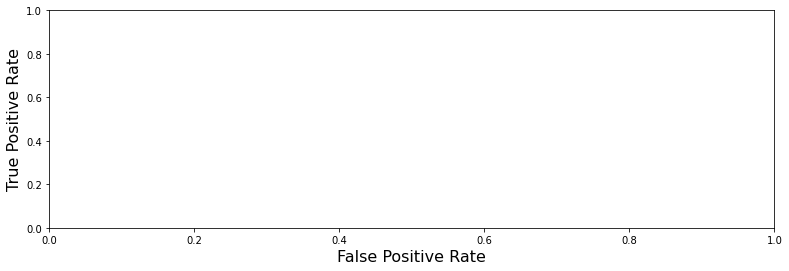

<Figure size 432x288 with 0 Axes>

In [ ]:
_,y_test = ms.importDataSet('./bestModels/Classifier/10-18-08/2208051018prediction_basin1Test.csv', 'prediction')
unique, count = np.unique(y_test, return_counts=True)
total = count.sum()
print(total)
percent = np.round(np.zeros_like(unique).astype('float16'),3)
print('values, counts , percent')
for i in range(len(unique)):    
   percent[i] = (count[i]/total)*100
   print(unique[i],"\t", count[i], percent[i])


## WhiteBoxTool applications

In [ ]:
import whiteboxApplications as wbtapp

In [ ]:
wdir = '/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodMaps/WBTWorkDir'
rtools = wbtapp.rasterTools(wdir)

In [ ]:
for i in range(0,10):
    rtools.gaussianFilter('basin1_FAccDInfLogGauss2.tif', 'basin1_FAccDInfLogGauss2.tif', sigma = 0.70)